## Домашка

### Задание 1 (8 баллов)
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на Recall@Precision меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


### Задание 2 (2 балла)
Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности с помощью CNN, а затем обратное увеличение длины последовательности до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями.
Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже.

Для повышения размерности используйте keras.layers.UpSampling1D
Полученная модель должна давать ненулевое качество на той же самой задаче классификации текстов.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
print(keras.__version__)

3.8.0


In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv(r'lenta_40k.csv.zip')

In [6]:
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [7]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [8]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [9]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [10]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [11]:
id2word = {i:word for word, i in word2id.items()}

In [12]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [14]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)
MAX_LEN, int(MEAN_LEN)

(200, 170)

In [16]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(44356, 200)

In [17]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [18]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [21]:
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5',
                                                monitor='val_rec@prec',
                                                verbose=1,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='max',
                                                save_freq='epoch'
                                               )

early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01,
                                              patience=5,
                                              verbose=1,
                                              mode='max',
                                              )

In [22]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

for ks in [3,4,5,7,10]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=24, padding='same',strides=1,
                                  kernel_regularizer='l2', activation='relu')(conv1)
    pool = keras.layers.AveragePooling1D(pool_size=5)(conv2)
    drop = keras.layers.Dropout(0.3)(pool)
    convs.append(drop)

concat = keras.layers.concatenate(convs, axis=2)

conv_global = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = keras.layers.Flatten()(conv_global)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 200, 100)       │      2,409,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 200, 32)        │          9,632 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 200, 32)        │         12,832 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 200, 32)        │         16,032 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 200, 32)        │         22,432 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 200, 32)        │         32,032 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 200, 24)        │          2,328 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 200, 24)        │          3,096 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 200, 24)        │          3,864 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 200, 24)        │          5,400 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 200, 24)        │          7,704 │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d         │ (None, 40, 24)         │              0 │ conv1d_1[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_1       │ (None, 40, 24)         │              0 │ conv1d_3[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_2       │ (None, 40, 24)         │              0 │ conv1d_5[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_3       │ (None, 40, 24)         │              0 │ conv1d_7[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_4       │ (None, 40, 24)         │              0 │ conv1d_9[0][0]         │
│ (AveragePooling1D)        │                        │                │                        │
├──────────────────────

 Total params: 2,602,403 (9.93 MB)

 Trainable params: 2,602,403 (9.93 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/backend/torch/nn.py:466: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  outputs = tnn.conv1d(


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 1.4171 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 402ms/step - loss: 1.4115 - rec@prec: 0.0000e+00 - val_loss: 1.0014 - val_rec@prec: 0.0000e+00
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 0.9079 - rec@prec: 1.2376e-05
Epoch 2: val_rec@prec improved from 0.00000 to 0.00631, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - loss: 0.9045 - rec@prec: 1.1838e-05 - val_loss: 0.6478 - val_rec@prec: 0.0063
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - loss: 0.5855 - rec@prec: 0.0249
Epoch 3: val_rec@prec improved from 0.00631 to 0.08161, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - loss: 0.5832 - rec@prec: 0.0257 - val_loss: 0.4176 - val_rec@prec: 0.0816
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 0.3739 - rec@prec: 0.2208
Epoch 4: val_rec@pre

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


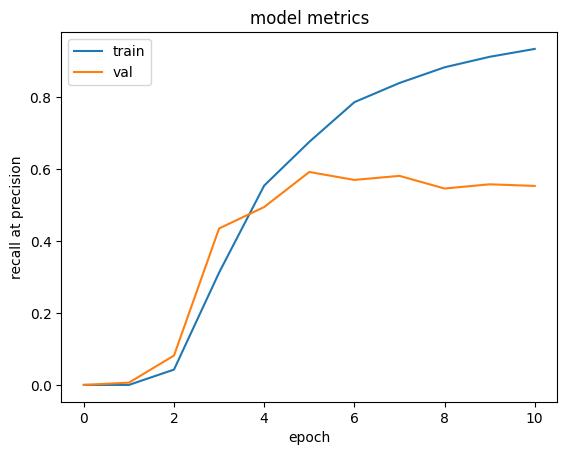

In [25]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Задача 2

In [45]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

down_сonv_1 = keras.layers.Conv1D(kernel_size=5, filters=128, strides=1, activation='relu', padding='same')(embeddings)
max_pool_1 = keras.layers.MaxPool1D(pool_size=2)(down_сonv_1)
down_сonv_2 = keras.layers.Conv1D(kernel_size=3, filters=64, strides=1, activation='relu', padding='same')(max_pool_1)
max_pool_2 = keras.layers.MaxPool1D(pool_size=2)(down_сonv_2)
down_сonv_3 = keras.layers.Conv1D(kernel_size=4, filters=16, strides=1, activation='relu', padding='same')(max_pool_2)
max_pool_3 = keras.layers.MaxPool1D(pool_size=2)(down_сonv_3)
down_conv_4 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu', padding='same')(max_pool_3)

up_sample_1 = keras.layers.UpSampling1D(2)(down_conv_4)
concat_1 = keras.layers.concatenate((up_sample_1, down_сonv_3), axis = -1)
up_сonv_1 = keras.layers.Conv1D(kernel_size=4, filters=16, strides=1, activation='relu', padding='same')(concat_1)
up_sample_2 = keras.layers.UpSampling1D(2)(up_сonv_1)
concat_2 = keras.layers.concatenate((up_sample_2, down_сonv_2), axis = -1)
up_сonv_2 = keras.layers.Conv1D(kernel_size=3, filters=32, strides=1, activation='relu', padding='same')(concat_2)
up_sample_3 = keras.layers.UpSampling1D(2)(up_сonv_2)
concat_3 = keras.layers.concatenate((up_sample_3, down_сonv_1), axis = -1)
up_сonv_3 = keras.layers.Conv1D(kernel_size=5, filters=64, strides=1, activation='relu', padding='same')(concat_3)

flatten = keras.layers.Flatten()(up_сonv_3)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(flatten)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [46]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_17 (Embedding)  │ (None, 200, 100)       │      2,409,200 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_94 (Conv1D)        │ (None, 200, 128)       │         64,128 │ embedding_17[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_48          │ (None, 100, 128)       │              0 │ conv1d_94[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_95 (Conv1D)        │ (None, 100, 64)        │         24,640 │ max_pooling1d_48[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_49          │ (None, 50, 64)         │              0 │ conv1d_95[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_96 (Conv1D)        │ (None, 50, 16)         │          4,112 │ max_pooling1d_49[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_50          │ (None, 25, 16)         │              0 │ conv1d_96[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_97 (Conv1D)        │ (None, 25, 32)         │          2,592 │ max_pooling1d_50[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_27          │ (None, 50, 32)         │              0 │ conv1d_97[0][0]        │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_28            │ (None, 50, 48)         │              0 │ up_sampling1d_27[0][0… │
│ (Concatenate)             │                        │                │ conv1d_96[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_98 (Conv1D)        │ (None, 50, 16)         │          3,088 │ concatenate_28[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_28          │ (None, 100, 16)        │              0 │ conv1d_98[0][0]        │
│ (UpSampling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_29            │ (None, 100, 80)        │              0 │ up_sampling1d_28[0][0… │
│ (Concatenate)             │                        │                │ conv1d_95[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_99 (Conv1D)        │ (None, 100, 32)        │          7,712 │ concatenate_29[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling1d_29     

 Total params: 2,809,955 (10.72 MB)

 Trainable params: 2,809,955 (10.72 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.1836 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec did not improve from 0.60325
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - loss: 0.1832 - rec@prec: 0.0000e+00 - val_loss: 0.1660 - val_rec@prec: 4.5086e-04
Epoch 2/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 0.1627 - rec@prec: 0.0013    
Epoch 2: val_rec@prec did not improve from 0.60325
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step - loss: 0.1622 - rec@prec: 0.0017 - val_loss: 0.1403 - val_rec@prec: 0.0428
Epoch 3/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - loss: 0.1325 - rec@prec: 0.0741
Epoch 3: val_rec@prec did not improve from 0.60325
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - loss: 0.1321 - rec@prec: 0.0760 - val_loss: 0.1215 - val_rec@prec: 0.1646
Epoch 4/20
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 0.1020 - rec@prec: 0.3551
Epoch 4: val_rec@prec did not improve from 0.60325
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - loss: 0.1014 - rec@prec: 0.3633 - val_loss

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


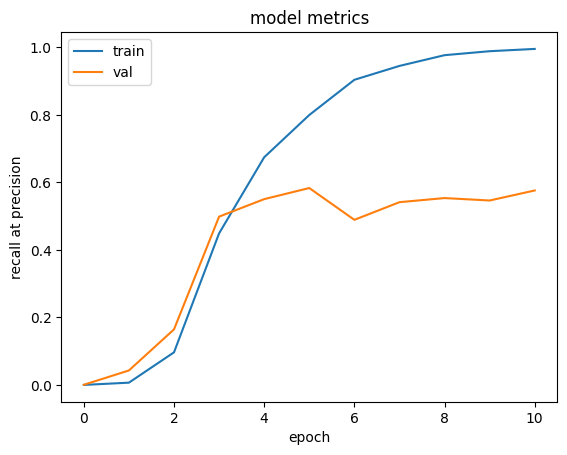

In [48]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()